### Import Required Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.random import set_seed
import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
set_seed(42)

# Download stock data
ticker_symbol = 'GOOGL'
ticker_data = yf.Ticker(ticker_symbol)
df = ticker_data.history(period='1d', start='2015-11-01', end='2023-11-09')
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df

,Date,Close
0,2015-11-02 00:00:00-05:00,37.387001
1,2015-11-03 00:00:00-05:00,37.441002
2,2015-11-04 00:00:00-05:00,37.765499
3,2015-11-05 00:00:00-05:00,38.033501
4,2015-11-06 00:00:00-05:00,38.080002
...,...,...
2014,2023-11-02 00:00:00-04:00,127.489998
2015,2023-11-03 00:00:00-04:00,129.100006
2016,2023-11-06 00:00:00-05:00,130.250000
2017,2023-11-07 00:00:00-05:00,130.970001


### Data Preprocessing

In [3]:
# Data is scaled to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_len = int(np.ceil(len(df) * 0.8))
scaler.fit(df['Close'].values[:training_data_len].reshape(-1, 1))
scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

In [4]:
# Create the training and testing data set
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [5]:
# Split the data into x_train and y_train data sets
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])  

In [6]:
# Create the x_test and y_test data sets
x_test, y_test = [], df['Close'][training_data_len:].values
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [7]:
# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [8]:
# Reshape data for SVR - we do not need 3D data here
x_train_svr = x_train.reshape(-1, x_train.shape[1])
x_test_svr = x_test.reshape(-1, x_test.shape[1])  

### Build the SVM Model

In [9]:
# Train the SVR Model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_model.fit(x_train_svr, y_train)

SVR(C=100, gamma=0.1)

### Evaluate the Model and Print RMSE

In [10]:
# Predict on training and test set
train_predictions_svr = svr_model.predict(x_train_svr)
test_predictions_svr = svr_model.predict(x_test_svr)

In [11]:
# Inverse transform to original form
train_predictions_svr = scaler.inverse_transform(train_predictions_svr.reshape(-1, 1))
test_predictions_svr = scaler.inverse_transform(test_predictions_svr.reshape(-1, 1))

In [12]:
# Calculate RMSE performance metrics
train_rmse_svr = np.sqrt(mean_squared_error(scaler.inverse_transform(y_train.reshape(-1, 1)), train_predictions_svr))
test_rmse_svr = np.sqrt(mean_squared_error(y_test, test_predictions_svr))
print(f"Train RMSE (SVR): {train_rmse_svr}, Test RMSE (SVR): {test_rmse_svr}")

Train RMSE (SVR): 5.682795216740236, Test RMSE (SVR): 10.268360762973629


### Visualize the Training Data and Predictions

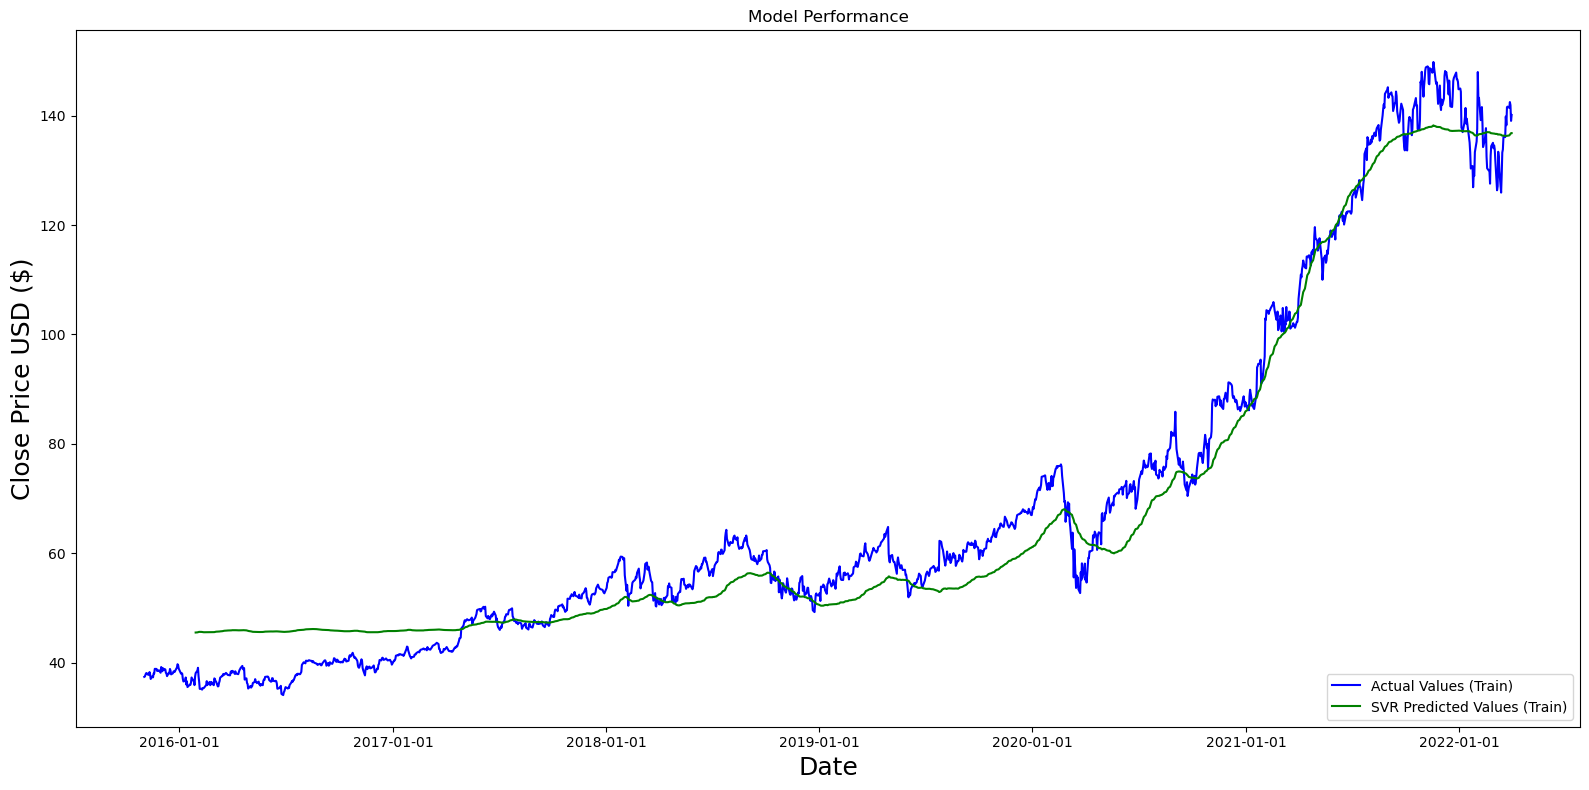

In [13]:
# Visualize the Training Data and Predictions
df['Date'] = pd.to_datetime(df['Date'])
adjusted_train_dates = df['Date'][60:training_data_len]

plt.figure(figsize=(16, 8))
plt.title('Model Performance')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(df['Date'][:training_data_len], scaler.inverse_transform(train_data)[:training_data_len, 0], label='Actual Values (Train)', color='blue')
plt.plot(adjusted_train_dates, train_predictions_svr, label='SVR Predicted Values (Train)', color='Green')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Forecasting the Next 365 Days with SVR

In [14]:
last_60_days = scaled_data[-60:]
forecasted_prices = []

for i in range(365):
    last_60_days_shaped = last_60_days.reshape(1, -1)
    next_price_scaled = svr_model.predict(last_60_days_shaped)
    forecasted_prices.append(next_price_scaled[0])
    last_60_days = np.append(last_60_days[1:], next_price_scaled)

forecasted_prices = scaler.inverse_transform(np.array(forecasted_prices).reshape(-1, 1))

last_date = df['Date'].iloc[-1]
prediction_dates = [last_date + pd.Timedelta(days=x + 1) for x in range(365)]

for i, price in enumerate(forecasted_prices):
    print(f"Predicted closing price for {prediction_dates[i].date()}: ${price[0]:.2f}")

Predicted closing price for 2023-11-09: $135.43
Predicted closing price for 2023-11-10: $135.53
Predicted closing price for 2023-11-11: $135.63
Predicted closing price for 2023-11-12: $135.71
Predicted closing price for 2023-11-13: $135.78
Predicted closing price for 2023-11-14: $135.84
Predicted closing price for 2023-11-15: $135.93
Predicted closing price for 2023-11-16: $136.07
Predicted closing price for 2023-11-17: $136.21
Predicted closing price for 2023-11-18: $136.27
Predicted closing price for 2023-11-19: $136.31
Predicted closing price for 2023-11-20: $136.32
Predicted closing price for 2023-11-21: $136.33
Predicted closing price for 2023-11-22: $136.34
Predicted closing price for 2023-11-23: $136.34
Predicted closing price for 2023-11-24: $136.38
Predicted closing price for 2023-11-25: $136.42
Predicted closing price for 2023-11-26: $136.44
Predicted closing price for 2023-11-27: $136.44
Predicted closing price for 2023-11-28: $136.42
Predicted closing price for 2023-11-29: 

### Visualize the Test Data and 365-Day Forecast

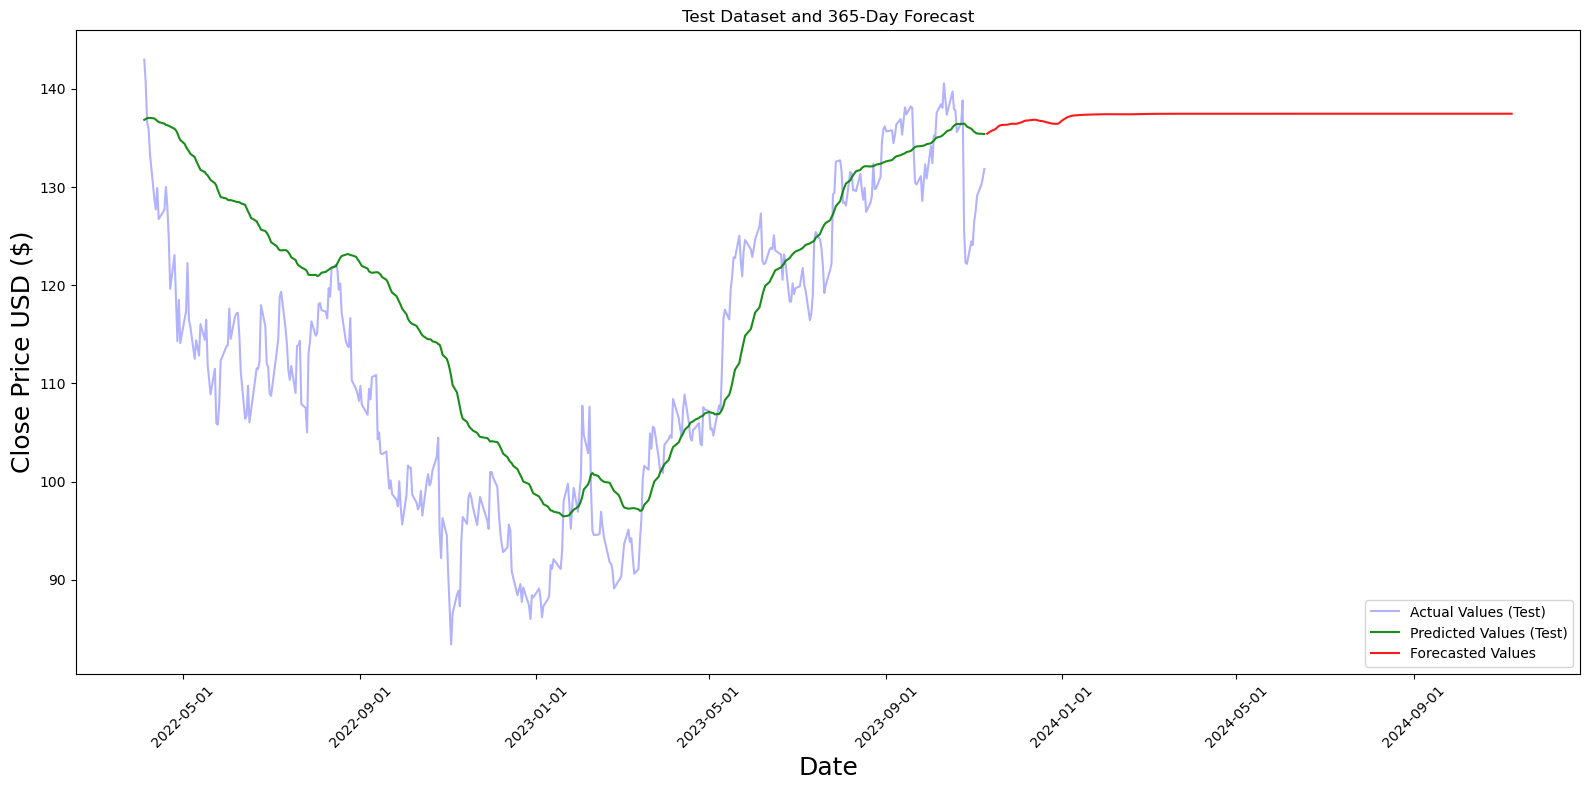

In [15]:
forecast_dates = [df['Date'].iloc[-1] + pd.Timedelta(days=x + 1) for x in range(1, 366)]
plt.figure(figsize=(16, 8))
plt.title('Test Dataset and 365-Day Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.plot(df['Date'][training_data_len:], y_test, label='Actual Values (Test)', color='Blue', alpha=0.3)
plt.plot(df['Date'][training_data_len:], test_predictions_svr.flatten(), label='Predicted Values (Test)', color='Green', alpha=0.9)
plt.plot(forecast_dates, forecasted_prices.flatten(), label='Forecasted Values', color='Red', alpha=0.9)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()